In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
business = []
for line in open('/Users/devanshimittal/Downloads/yelp_dataset/business.json', 'r'):
    business.append(json.loads(line))

In [3]:
review = []
for line in open('/Users/devanshimittal/Downloads/yelp_dataset/review.json', 'r'):
    review.append(json.loads(line))

In [4]:
tip = []
for line in open('/Users/devanshimittal/Downloads/yelp_dataset/tip.json', 'r'):
    tip.append(json.loads(line))

In [5]:
review_df = pd.DataFrame.from_dict(review)
business_df = pd.DataFrame.from_dict(business)
tip_df = pd.DataFrame.from_dict(tip)
#user_df = pd.DataFrame.from_dict(user)



In [6]:
from collections import Counter
category = business_df['categories'].to_list()
business_df.dropna(inplace=True)
restaurant_data = business_df[business_df['categories'].str.contains("Restaurants")]
rest_review = pd.merge(restaurant_data, review_df, on = 'business_id')
finaldata = pd.merge(rest_review , tip_df, on = ['business_id', 'user_id'])

In [7]:
finaldata = finaldata[['stars_y', 'text_x', 'text_y']]#.to_csv('finaldata.csv')

In [13]:
def cleanText(text):
    from bs4 import BeautifulSoup
    import re
    import string
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n','')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [14]:
finaldf['text'] = finaldf['text_x'].str.cat(finaldf['text_y'], sep =" ") 

In [15]:
full_cleaned = [cleanText(i) for i in finaldf['text']]

In [112]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [117]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(full_cleaned[:30000])
# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('/Users/devanshimittal/opt/anaconda3/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-2.2.5', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv


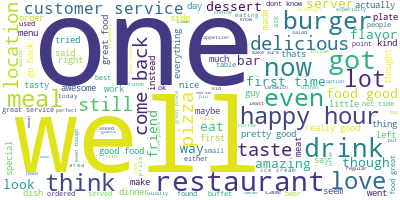

In [16]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(full_cleaned))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

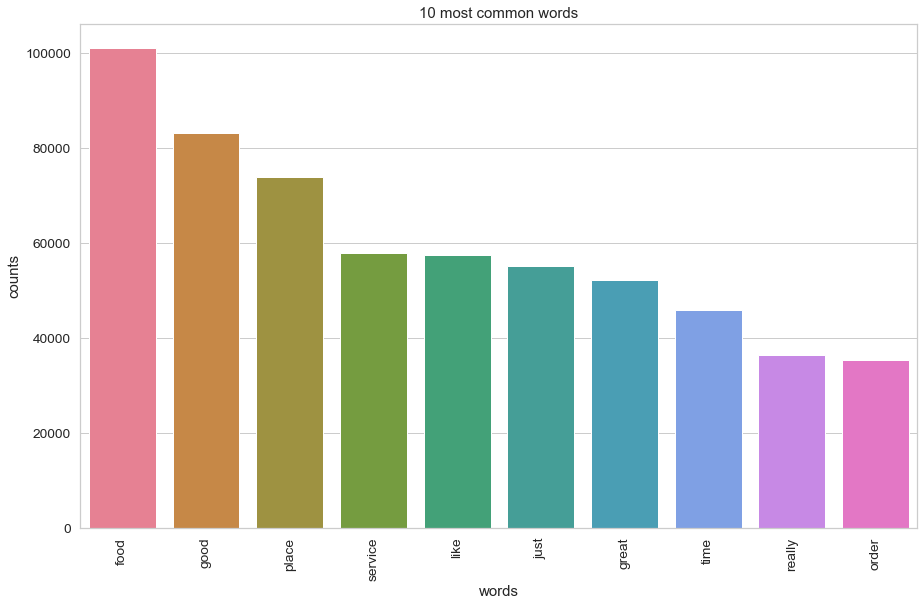

In [18]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(full_cleaned)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [19]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
sushi good lunch place food coffee roll tea like great

Topic #1:
rice fried pork sauce tacos chicken beef like good spicy

Topic #2:
place bar like beer just room night hotel good dont

Topic #3:
just like menu good breakfast try really cream chocolate restaurant

Topic #4:
pizza burger fries good cheese like just place ordered time

Topic #5:
salad good sandwich bread steak cheese menu crab pasta lobster

Topic #6:
good table really bar just ordered like came server got

Topic #7:
food service order time just place dont minutes like said

Topic #8:
food great place good service love best friendly staff amazing

Topic #9:
food chicken place like good just dont better meat really


## Trying one more way using particular values of alpha and eta.

In [53]:
from gensim import corpora, models

# list_of_list_of_tokens = [["a","b","c"], ["d","e","f"]]
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...
dictionary_LDA = corpora.Dictionary(data_words_nostops)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in data_words_nostops]

num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 7min 41s, sys: 20.1 s, total: 8min 1s
Wall time: 13min 41s


In [54]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.061*"sandwich" + 0.047*"cheese" + 0.021*"sandwiches" + 0.021*"fries" + 0.021*"hot" + 0.020*"bbq" + 0.018*"good" + 0.017*"bread" + 0.016*"meat" + 0.014*"mac"

1: 0.156*"good" + 0.114*"service" + 0.048*"great" + 0.032*"ok" + 0.024*"bad" + 0.024*"better" + 0.024*"pretty" + 0.022*"place" + 0.022*"price" + 0.022*"decent"

2: 0.025*"chicken" + 0.024*"good" + 0.023*"sauce" + 0.017*"like" + 0.015*"ordered" + 0.013*"fried" + 0.011*"cheese" + 0.011*"got" + 0.010*"fries" + 0.010*"flavor"

3: 0.111*"sushi" + 0.053*"roll" + 0.041*"rolls" + 0.037*"fish" + 0.025*"salmon" + 0.025*"tuna" + 0.022*"ayce" + 0.020*"sashimi" + 0.017*"fresh" + 0.015*"rice"

4: 0.013*"would" + 0.011*"menu" + 0.010*"like" + 0.009*"bit" + 0.009*"really" + 0.008*"restaurant" + 0.008*"little" + 0.007*"quite" + 0.007*"one" + 0.007*"small"

5: 0.052*"tacos" + 0.045*"chips" + 0.040*"pho" + 0.035*"taco" + 0.035*"salsa" + 0.033*"meican" + 0.030*"burrito" + 0.022*"fish" + 0.018*"beans" + 0.013*"nachos"

6: 0.055*"salad" + 0.047*"c